Need to figure out what's consuming memory on nnpz. Apparently, memory keeps increasing even though the output had been already pre-allocated.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mprof_path = '/home/aalvarez/Work/Projects/NNPZ/profiles/mprofile_20180502093630.dat'

In [3]:
def read_mprof(path):
    times = []
    mem = []
    with open(path) as fd:
        for l in fd:
            key, val = l.split(' ', 1)
            if key == 'MEM':
                values = val.split(' ')
                mem.append(float(values[0]))
                times.append(float(values[1]))
    return np.array([times, mem]).transpose()

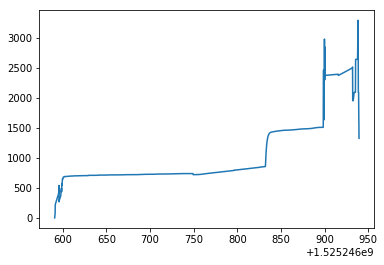

In [4]:
mprof_data = read_mprof(mprof_path)
_ = plt.plot(mprof_data[:, 0], mprof_data[:, 1])

This is a run with the full test catalog. Indeed there are sharp memory increases. Not entirely sure, but they seem to happen roughly when computing the weights, when adding the contributions, and when dumping the file (?)
Need to be check with more details what's happening.

```
Line #    Mem usage    Increment   Line Contents
================================================
    33    670.0 MiB    670.0 MiB       @profile
    34                                 def findAffected(self, input_coord_iter, flags_iter, progress_listener=None):
    ...
    52    670.0 MiB      0.0 MiB           result = {}
    53    751.9 MiB      4.6 MiB           for i, (in_data, flags) in enumerate(zip(input_coord_iter, flags_iter)):
    54    751.9 MiB      0.0 MiB               if progress_listener:
    55    751.9 MiB      0.0 MiB                   progress_listener(i+1)
    56    751.9 MiB     44.0 MiB               neighbor_indices, _ = self.__selector.findNeighbors(in_data, flags)
    57    751.9 MiB      2.0 MiB               for ref_i in neighbor_indices:
    58    751.9 MiB      0.4 MiB                   if not ref_i in result:
    59    751.9 MiB      0.2 MiB                       result[ref_i] = []
    60    751.9 MiB     12.8 MiB                   result[ref_i].append(i)
    61    734.0 MiB    -17.9 MiB           return result
```

I don't understand why does it say "4.6" when there is an increase of 80 MiB :/

```
Line #    Mem usage    Increment   Line Contents
================================================
    36    734.0 MiB    734.0 MiB       @profile
    37                                 def computeWeights(self, affected, target_data, result_flags, progress_listener):
...
    50                                     # Note that we iterate the affected map in increasing order of the reference
    51                                     # sample indices. This is done to use as much the cache of the disk, by accessing
    52                                     # the SEDs sequentially.
    53    734.0 MiB      0.0 MiB           weights = {}
    54                             
    55                                     # All weights of a target object are 0 if their sum is 0
    56    734.0 MiB      0.0 MiB           weight_sum_per_target = np.zeros(target_data.shape[0], dtype=np.float32)
    57                             
    58                                     # A map where the key is a tuple (ref index, target_index), and the value
    59                                     # an alternative weight precomputed if the preferred one was 0
    60    734.0 MiB      0.0 MiB           alt_weights = {}
    61                             
    62                                     # A map to keep track of the references that are a neighbor of a given target
    63    734.0 MiB      0.0 MiB           alt_neighbors = {}
    64                             
    65    734.0 MiB      0.0 MiB           filters_shape = target_data.shape[1:]
    66    869.8 MiB      0.0 MiB           for progress, ref_i in enumerate(sorted(affected)):
    67    869.8 MiB      0.0 MiB               progress_listener(progress)
    68                             
    69                                         # Affected targets
    70    869.8 MiB      0.0 MiB               target_i_list = affected[ref_i]
    71                             
    72                                         # Get the reference sample object photometry to use for the weight calculation
    73    869.8 MiB     10.7 MiB               ref_obj = np.ndarray((len(target_i_list),) + filters_shape, dtype=np.float32)
    74    869.8 MiB      0.0 MiB               for i, target_i in enumerate(target_i_list):
    75    869.8 MiB      0.0 MiB                   flag = result_flags[target_i]
    76    869.8 MiB      0.0 MiB                   ref_obj[i, :, :] = self._weight_phot_provider(ref_i, target_i, flag)
    77                             
    78    869.8 MiB      0.0 MiB               weights[ref_i] = _apply_weight_calculator(
    79    869.8 MiB    121.1 MiB                   self._weight_calculator, target_i_list, ref_obj, target_data, result_flags
    80                                         )
    81                             
    82    869.8 MiB      0.0 MiB               for target_i, w in zip(target_i_list, weights[ref_i]):
    83    869.8 MiB      0.0 MiB                   weight_sum_per_target[target_i] += w
    84                             
    85                                         # Since we have the photometry calculated here already, and
    86                                         # computing it is expensive, for weights that are 0 with the preferred method
    87                                         # we apply an alternative method, and keep it for later, in case all weights
    88                                         # for a given target are 0
    89    869.8 MiB      0.0 MiB               if self._weight_calculator_alt:
    90                                             target_i_zero_weights = [
    91    869.8 MiB      0.0 MiB                       target_i for target_i, ref_w in zip(target_i_list, weights[ref_i]) if ref_w == 0
    92                                             ]
    93                                             ref_obj_zero_weights = [
    94    869.8 MiB      0.0 MiB                       ref_obj for ref_obj, ref_w in zip(ref_obj, weights[ref_i]) if ref_w == 0
    95                                             ]
    96    869.8 MiB      0.0 MiB                   new_weights = _apply_weight_calculator(
    97    869.8 MiB      0.3 MiB                       self._weight_calculator_alt, target_i_zero_weights, ref_obj_zero_weights, target_data, result_flags
    98                                             )
    99    869.8 MiB      0.0 MiB                   for target_i, w in zip(target_i_zero_weights, new_weights):
   100    869.8 MiB      3.9 MiB                       alt_weights[(ref_i, target_i)] = w
   101    869.8 MiB      0.0 MiB                       if target_i not in alt_neighbors:
   102    860.3 MiB      0.0 MiB                           alt_neighbors[target_i] = list()
   103    869.8 MiB      0.0 MiB                       alt_neighbors[target_i].append(ref_i)
   104                             
   105                                     # For target objects with *all* their weights being 0, override with the alternative
   106    869.8 MiB      0.0 MiB           all_zero_mask = (weight_sum_per_target == 0)
   107    869.8 MiB      0.0 MiB           all_zero_i = np.arange(len(weight_sum_per_target))[all_zero_mask]
   108                             
   109    869.8 MiB      0.0 MiB           if len(all_zero_i) > 0:
   110    869.8 MiB      0.0 MiB               log.debug('{} objects with all weights set to 0, using alternative weight'.format(len(all_zero_i)))
   111    869.8 MiB      0.0 MiB               log.debug(all_zero_i)
   112                             
   113    869.8 MiB      0.0 MiB           for target_i in all_zero_i:
   114                                         # Some target entries may not even have any neighbor
   115    869.8 MiB      0.0 MiB               for ref_i in alt_neighbors.get(target_i, []):
   116    869.8 MiB      0.0 MiB                   offset = affected[ref_i].index(target_i)
   117    869.8 MiB      0.0 MiB                   weights[ref_i][offset] = alt_weights[(ref_i, target_i)]
   118    869.8 MiB      0.0 MiB               result_flags[target_i] |= NnpzFlag.AlternativeWeightFlag
   119                             
   120    869.8 MiB      0.0 MiB           return weights
```

Doesn't look crazy. Anyway, I can see how the memory consumption start growing at "Adding contributions"...

```
Line #    Mem usage    Increment   Line Contents
================================================
   122    869.8 MiB    869.8 MiB   @profile
   123                             def addcontrib_wrap():
   124    869.8 MiB      0.0 MiB       progress_listener = ProgressListener(len(affected)-1, 'Adding contributions to output...')
   125   1525.1 MiB      0.0 MiB       for progress, ref_i in enumerate(sorted(affected)):
   126   1525.1 MiB      0.0 MiB           progress_listener(progress)
   127   1525.1 MiB      0.0 MiB           for target_i, w in zip(affected[ref_i], weights[ref_i]):
   128   1525.1 MiB    655.3 MiB               output.addContribution(ref_i, target_i, w, result_flags[target_i])
```

This one duplicates the memory usage.

```
Line #    Mem usage    Increment   Line Contents
================================================
   133   1525.1 MiB   1525.1 MiB   @profile
   134                             def save_wrap():
   135   2111.7 MiB    586.6 MiB       output.save(output_file)
```

This one is pretty bad as well! And surprisingly so. Shouldn't it just be writing?

Some hints:
  * Almost all output providers pre-allocate the required memory, *but* for the neighbors+weight lists, they are appended in each iteration, so that provider grows in memory during execution
  * I think that the output table copies the columns. Also, I think that creating the hdu from the table generates yet another copy of the very same data. There is 1.2 GiB difference on save between its entry and exit!
  * When generating columns, there are operations that generate new arrays

```
Line #    Mem usage    Increment   Line Contents
================================================
    69   1505.6 MiB   1505.6 MiB       @profile
    70                                 def save(self, filename):
    71   1505.6 MiB      0.0 MiB           hdu_list = []
    72                             
    73                                     # Primary hdu
    74   1505.6 MiB      0.0 MiB           hdr = fits.Header()
    75   1505.6 MiB      0.0 MiB           hdr['COMMENT'] = 'Generated by nnpz'
    76   1505.6 MiB      0.0 MiB           hdu_list.append(fits.PrimaryHDU(header=hdr))
    77                             
    78                                     # Table with the results
    79   1505.6 MiB      0.0 MiB           out = Table()
    80   2090.6 MiB      0.0 MiB           for prov in self.__column_providers:
    81   2090.6 MiB    585.1 MiB               out.add_columns(prov.getColumns(), copy=False)
    82   2635.3 MiB    544.6 MiB           hdu_list.append(tableToHdu(out))
    83                             
    84                                     # Extensions
    85   2635.5 MiB      0.0 MiB           for hp in self.__hdu_providers:
    86   2635.5 MiB      0.2 MiB               for name, table in hp.getExtensionTables().items():
    87   2635.5 MiB      0.0 MiB                   ext_hdu = tableToHdu(table)
    88   2635.5 MiB      0.0 MiB                   ext_hdu.name = name
    89   2635.5 MiB      0.0 MiB                   hdu_list.append(ext_hdu)
    90                             
    91   2635.5 MiB      0.0 MiB           hdul = fits.HDUList(hdu_list)
    92                             
    93   2635.5 MiB      0.0 MiB           if os.path.exists(filename):
    94   2635.5 MiB      0.0 MiB               os.remove(filename)
    95   2635.5 MiB      0.0 MiB           hdul.writeto(filename)
```
Writing the output is actually expensive :(

```
#9: output_column_providers/NeighborList.py:22: 2734.4 KiB
    self.__weights[catalog_i].append(weight)
#10: output_column_providers/NeighborList.py:21: 2734.4 KiB
    self.__neighbors[catalog_i].append(self.__ref_ids[reference_sample_i])
```
I think this confirms during addContribution this is where memory is allocated.